# Chapter 2: Pedometer and calorie tracker  

Pedometers are popular as an everyday exercise progress monitor and motivator. We look at the steps to go from 3-axis accelerometer readings to counting steps. Note that there are multiple ways to approach this problem, and what is described below is one approach.

In [53]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pylab as pl
from scipy.signal import butter, freqz, filtfilt, firwin, iirnotch, lfilter
matplotlib.style.use('ggplot')
%matplotlib notebook
import mpld3
mpld3.enable_notebook()

## Converting a 3-axis accelerometer signal into a 1-dimensional signal

The first step is somehow converting a 3-axis accelerometer signal into a one-dimensional signal that we can use for detecting peaks. 

In [54]:
def pull_data(dir_name, file_name):
    f = open(dir_name + '/' + file_name + '.csv')
    xs = []
    ys = []
    zs = []
    rs = []
    timestamps = []
    for line in f:
        value = line.split(',')
        if len(value) > 3:
            timestamps.append(float(value[-4]))
            x = float(value[-3])
            y = float(value[-2])
            z = float(value[-1])
            r = math.sqrt(x ** 2 + y ** 2 + z ** 2)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            rs.append(r)
    return np.array(xs), np.array(ys), np.array(zs), np.array(rs), np.array(timestamps)


## Case study 1: Step Counting

Let us look at how to extract steps from the raw time-series. Let us first plot the three-axis accelerometer readings. 

In [55]:
# read accelerometer data file

accel_file = 'data/walk/inPocket/john1'
x_data, y_data, z_data, signal, timestamps = pull_data(accel_file, 'accelerometer')

c = timestamps[0]
timestamps = (timestamps - c)/1000000000

**ASSIGNMENT:** Plot acceleration readings along each of the three axes

<IPython.core.display.Javascript object>


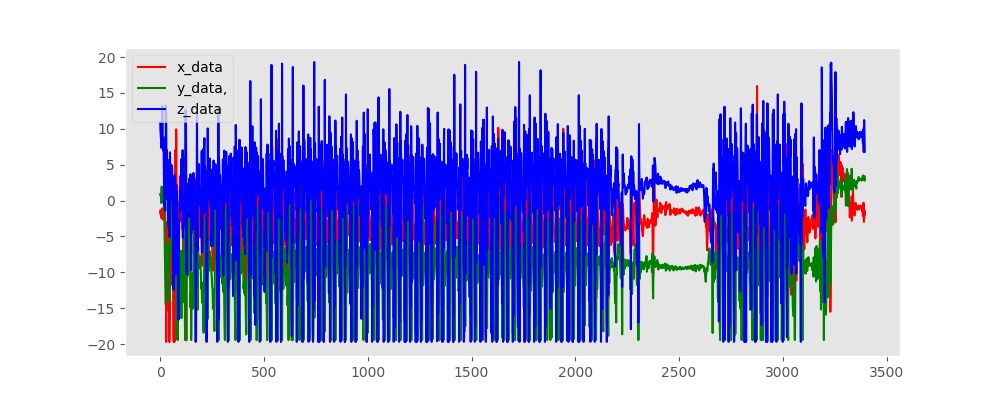

In [56]:
# FILL IN CODE: plot three-axis acceleration
plt.figure(figsize=(10,4))
pl.plot(x_data, 'r-', label='x_data')
pl.grid()
pl.plot(y_data, 'g-', label='y_data')
pl.grid()
pl.plot(z_data, 'b-', label='z_data')
pl.grid()
plt.legend(['x_data', 'y_data,', 'z_data'])
pl.show()

### Using magnitude rather than 3-axis signal

One issue with using the 3 axis signal directly is that the shape of the x, y, z curves depends on the orientation of the phone (or smartwatch). The acceleration changes as a result of the step can result in changes along all the three axes, so we need to design an orientation-independent algorithm. The easiest way to do this is to use the magnitude of the signal across all the three axes.

**ASSIGNMENT:** Plot the magnitude of acceleration

<IPython.core.display.Javascript object>


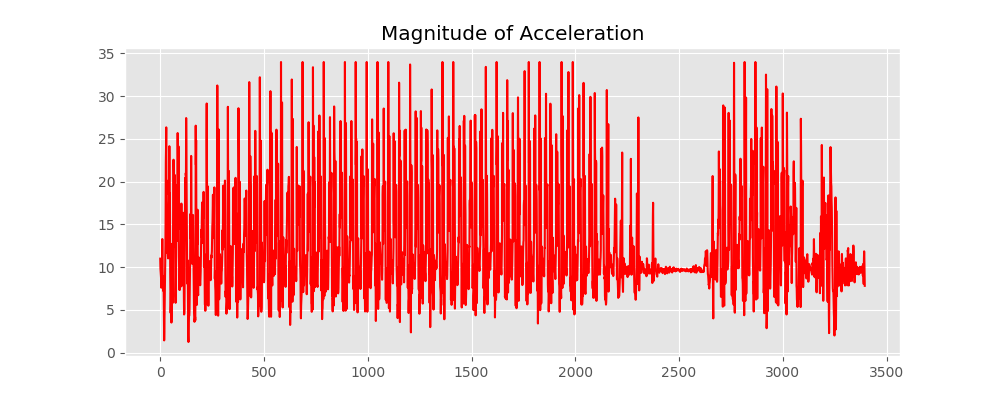

In [57]:
# FILL IN CODE: plot magnitude
magnitude = np.sqrt(x_data**2 + y_data**2 + z_data**2)
plt.figure(figsize=(10,4))
plt.title("Magnitude of Acceleration")
plt.plot(magnitude, 'r-', label='magnitude')

### Cleaning the accelerometer magnitude signal with a butterworth filter

We are now going to use a frequency domain filter called a 'butterworth filter' to remove noise (see previous notebook for further explanation of frequency-domain filtering). A Butterworth filter is a popular frequency domain 'lowpass' filter that can remove high frequency noise while only letting the low frequencies through. Since the walking signal is low frequency (only a few steps minute), this is a good approach.

**ASSIGNMENT:** Apply a Butterworth filter (as demonstrated in the previous notebook) and plot both unfiltered and filtered accelerometer signals (magnitude only).

<IPython.core.display.Javascript object>


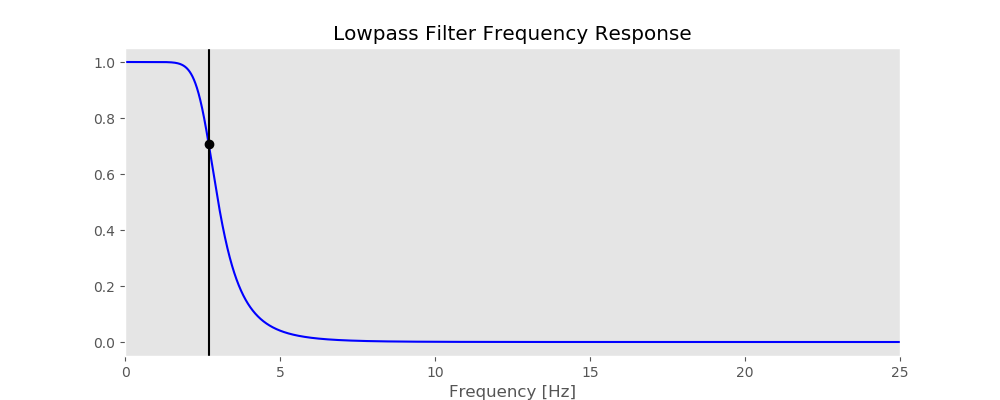

In [58]:
# FILL IN CODE: Create and apply Butterworth filter
order = 5
fs = 50.0  # sample rate, Hz
cutoff = 2.7  # desired cutoff frequency of the filter, Hz. MODIFY AS APPROPROATE

# Create the filter.
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='low', analog=False)

# Frequency response graph
w, h = freqz(b, a, worN=8000)
plt.figure(figsize=(10,4))

plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5 * np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5 * fs)
plt.title('Lowpass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

# Apply the butterworth filter on the signal
filtered_signal = filtfilt(b, a, signal)

<IPython.core.display.Javascript object>


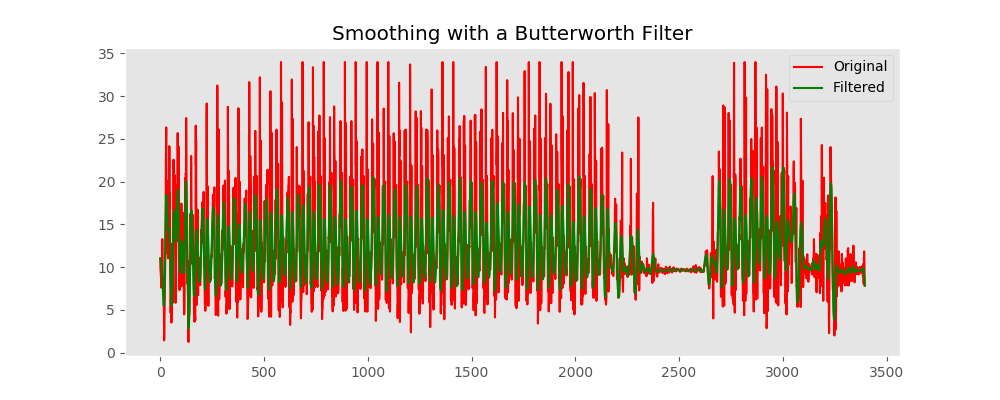

In [59]:
# FILL IN CODE: Plot signals
plt.figure(figsize=(10,4))
plt.plot(magnitude, 'r-', label='unfiltered')
plt.plot(filtered_signal, 'g-', label='filtered')
plt.legend(['Original','Filtered'])
plt.title("Smoothing with a Butterworth Filter")
plt.grid()
plt.show()

### Counting steps

Our next problem is to determine when a step occurs. From looking at the figure, you could probably come up with a few potential algorithms. For example, we could extract the peak point of each step or look for crossings of the mean signal value. Note that the person seems to have stopped for a few seconds during his walk, where the signal is oscillating slightly about the mean value. It is important to carefully consider such changes since the threshold values could change depending on the current activity.

**ASSIGNMENT:** From the filtered signal, determine the number of steps taken by the person. You can use one of the abovementioned methods or implement your own algorithm to do so. Plot the filtered signal and the detected steps.

No. of steps=  1465


<IPython.core.display.Javascript object>


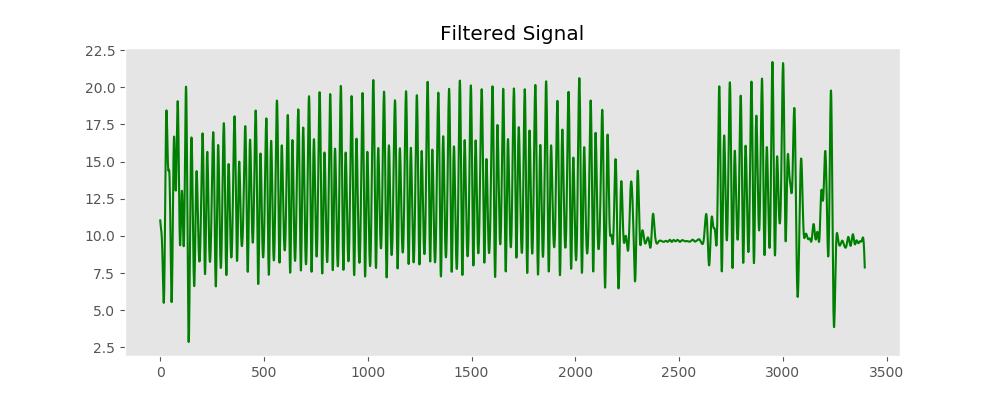

In [61]:
# FILL IN CODE: Step counting
ctr = 0   #no. of steps
num = 0   #no. of signal peaks
sum = 0   #sum of signals
for i in filtered_signal:
    sum = i + sum
    num = num + 1
avg = sum/num
for i in filtered_signal:
    if i > avg:
        ctr= ctr +1
print("No. of steps= ", ctr)
plt.figure(figsize=(10,4))
plt.plot(filtered_signal, 'g-', label='filtered')
plt.title("Filtered Signal")
plt.grid()
plt.show()